In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA       

In [206]:
data = pd.read_csv("/Users/seydanurkayir/Desktop/iyzico-datathon/train.csv")
data.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428


In [207]:
data[["Merchant", "ID"]] = data["merchant_id"].str.split("_", expand=True)

In [208]:
train = data.drop(['merchant_id','Merchant','merchant_source_name','settlement_period',
                      'working_type','mcc_id','merchant_segment'], axis=1)
train

,month_id,net_payment_count,ID
0,202307,15106,43992
1,202301,16918,43992
2,202305,13452,43992
3,202308,16787,43992
4,202302,12428,43992
...,...,...,...
291137,202309,4,67083
291138,202309,4,4263
291139,202309,3,11346
291140,202309,3,21397


In [209]:
train = train.sort_values(by=['ID', 'month_id'])
train.head(10)


,month_id,net_payment_count,ID
234370,202108,3,1
234371,202210,3,1
249229,202111,6,10
249226,202112,24,10
249224,202201,15,10
249225,202202,7,10
249227,202203,9,10
249228,202204,4,10
269591,202205,3,10000
269590,202206,4,10000


In [210]:
train['month_id'] = pd.to_datetime(train['month_id'], format='%Y%m').dt.strftime('%Y-%m')
train['ID'] = train['ID'].astype('int')
train['month_id'] = pd.to_datetime(train['month_id'], format='%Y-%m').dt.tz_localize(None)

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291142 entries, 234370 to 277529
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   month_id           291142 non-null  datetime64[ns]
 1   net_payment_count  291142 non-null  int64         
 2   ID                 291142 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 8.9 MB


In [241]:
train.set_index('month_id', inplace=True)

train.index

DatetimeIndex(['2021-08-01', '2022-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01',
               ...
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-06-01'],
              dtype='datetime64[ns]', name='month_id', length=291142, freq=None)

In [242]:
train

,net_payment_count,ID
month_id,,
2021-08-01,3,1
2022-10-01,3,1
2021-11-01,6,10
2021-12-01,24,10
2022-01-01,15,10
...,...,...
2022-11-01,3,9993
2022-12-01,3,9993
2023-01-01,3,9993


In [239]:
df = train[train['ID'] == 9993].sort_values(by=['month_id'])


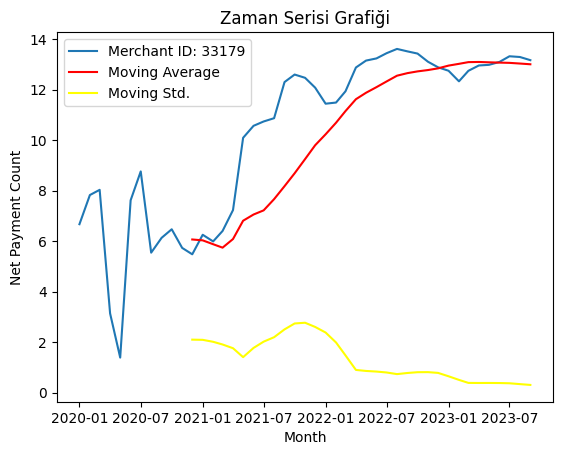

In [243]:
def plot_merchant(train, id):
    data = train[train['ID'] == id]
    merchant_data = data.sort_values(by=['month_id'])
    
    ts_log = np.log(merchant_data['net_payment_count'])
    moving_avg = ts_log.rolling(12).mean()
    moving_std = ts_log.rolling(12).std()
    #plt.plot(ts, color='red')
    plt.plot(ts_log, label=f'Merchant ID: {id}')
    plt.plot(moving_avg, color='red', label='Moving Average')
    plt.plot(moving_std, color='yellow', label='Moving Std.')

    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('Net Payment Count')
    plt.title('Zaman Serisi Grafiği')

    plt.show()


plot_merchant(train,33179)

/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Forecast for Merchant ID 33179:

                 Forecast
2023-10-01  556560.545675
2023-11-01  589087.546229
2023-12-01  547880.550622


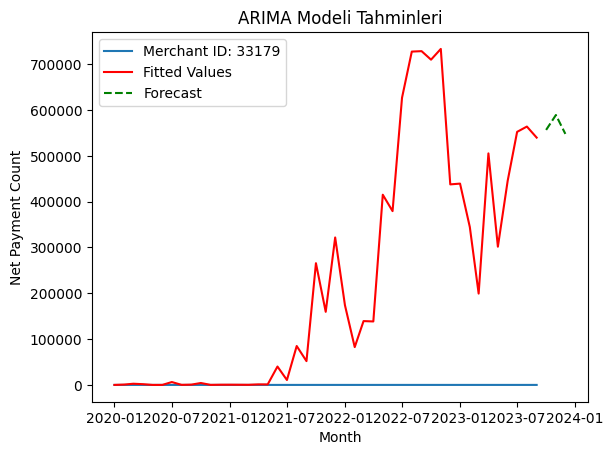

In [244]:
def forecast_merchant(train, id, forecast_periods=3):
    data = train[train['ID'] == id]
    merchant_data = data.sort_values(by=['month_id'])

    ts_log = np.log(merchant_data['net_payment_count'])

    # ARIMA modelini oluşturun ve eğitin
    model = sm.tsa.ARIMA(ts_log, order=(2, 1, 2))  
    results_ARIMA = model.fit()

    # Tahminleri alın
    forecast = results_ARIMA.get_forecast(steps=forecast_periods)

    # Tahminleri indeks ile eşleştirin
    forecast_index = pd.date_range(start=ts_log.index[-1], periods=forecast_periods+1, freq='MS')[1:]
    #forecast_index = forecast_index.strftime('%Y-%m')

    forecast_values = np.exp(forecast.predicted_mean)
    # Tahminleri DataFrame olarak oluşturun
    forecast_df = pd.DataFrame({
        'Forecast': forecast_values,
    }, index=forecast_index)

    # Tahminleri göster
    print(f"Forecast for Merchant ID {id}:\n")
    print(forecast_df)

    # Grafik üzerinde gösterim
    plt.plot(ts_log, label=f'Merchant ID: {id}')
    plt.plot(np.exp(results_ARIMA.fittedvalues), color='red', label='Fitted Values')
    plt.plot(forecast_df, color='green', linestyle='--', label='Forecast')
    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('Net Payment Count')
    plt.title('ARIMA Modeli Tahminleri')

    plt.show()

# Belirli bir 'id' için 3 aylık tahmin yapın
forecast_merchant(train, 33179, forecast_periods=3)

In [ ]:
# Her bir ID için son 3 ayı tahmin etmek
unique_ids = train['ID'].unique()
all_forecasts = pd.DataFrame()

for unique_id in unique_ids:
    forecast_result = forecast_merchant(train, unique_id,3)
    all_forecasts = pd.concat([all_forecasts, forecast_result])

# Elde edilen DataFrame'i göster
#print(all_forecasts)


In [249]:
unique_ids = train['ID'].unique()
unique_ids

array([    1,    10, 10000, ...,  9986,  9991,  9993])

In [252]:
df = train[train['ID'] == 10588].sort_values(by=['month_id'])
df

,net_payment_count,ID
month_id,,
2020-06-01,4,10588
2020-08-01,3,10588
